### Download of dataset

In [1]:
# Para fazer o download dos arquivos foi necessário instalar o kagglehub
#!pip install kagglehub --quiet

In [2]:
# Download dos arquivos
#import kagglehub

#path = kagglehub.dataset_download("claudiodavi/superhero-set")
#print("Path to dataset files:", path)

# Análise Exploratória

O objetivo deste notebook é entender os dados, identificar pontos que possam atrapalhar a modelagem e definir o racional de pré-processamento

## Conclusões

Apenas como melhor forma de organização vou apresentar a conclusões aqui no início. 

### Dataset heroes_information

O dataset heroes_information possui 734 linhas, sendo 1 duplicada. Esta linha duplicado foi retirada.

Algumas features categóricas possuem uma string "-" indicando que o herói não possui a informação, valor nulo. Neste caso substituí o "-" pela string "Unknown". No entanto, em alguns casos as features: Eye color, Race e Hair color. São "Unknown", nos casos em que as 3 colunas não possuem informação eu retirei a linha do dataset, foram retiradas 5 linhas.

Para as variáveis numéricas (Height e Weight) existem muitos casos onde os valores são -99. Essas colunas possuem 29% e 32%, respectivamente, de casos onde o valor é -99. Optei por retirar do dataframe as linhas onde as duas colunas possuem o valor -99. Após isso, os que restaram foram substituídos pela média. Sei que a média pode camuflar algumas informações, mas decidi assumir o risco.

As análises de correlação tanto das variáveis numéricas, usando o pearson, quanto das categóricas, usando o Cramér's V. Não mostram nenhuma correlação que justificasse a exclusão de alguma variável.

Como pode ser visto nos plots, boxplot e scatterplot, as colunas: Height e Weight. Possuem outliers. Retirei os outliers usando o método do intervalo interquartil (IQR).

A coluna Skin color possui 90% de valores faltantes. Sendo assim, decidi remover esta coluna.

A coluna Race tem 35% de humanos, 35% valores faltantes e o restante distribuído entre outras raças. 

| Raça     | Proporção   |
|----------|-------------|
| Unknown  | 0.356061    |
| Human    | 0.356061    |
| Mutant   | 0.111111    |
| Android  | 0.012626    |
| Alien    | 0.012626    |

Temos duas raças com mais de 10% da base: Human e Mutant. Essa coluna não carrega informações relevantes, sendo assim, retirei elas da base de modelagem.

Alguns heróis possuem mesmo nome mas informações diferentes

| Name | Gender | Eye color | Race           | Hair color | Height | Publisher      | Alignment | Weight |
|------|--------|-----------|----------------|------------|--------|----------------|-----------|--------|
| Nova | Male   | brown     | Human          | Brown      | 185.0  | Marvel Comics  | good      | 86.0   |
| Nova | Female | white     | Human / Cosmic | Red        | 163.0  | Marvel Comics  | good      | 59.0   |

Não retirei da base esses casos.

Por fim a base ficou com 396 linhas.

### Dataset Super Hero Powers

Quanto a base de poderes, não possui nulos nem as features são correlacionadas o suficiente para descartar variáveis. Desta forma não fiz alterações na base.

### Arquivo python com o pré-processamento

Por fim, criei o arquivo preprocessing.py com as regras de pré-processamento que defini aqui.

In [3]:
# Bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List
from scipy.stats import chi2_contingency

pd.set_option('display.max_columns', None)

In [4]:
# leitura das bases
heroes_information = pd.read_csv("/Users/aurelianosancho/.cache/kagglehub/datasets/claudiodavi/superhero-set/versions/1/heroes_information.csv", index_col=0)
super_hero_powers = pd.read_csv("/Users/aurelianosancho/.cache/kagglehub/datasets/claudiodavi/superhero-set/versions/1/super_hero_powers.csv", index_col=0)

## Heroes Information explratory analysis

In [5]:
heroes_information.head(30)

,name,Gender,Eye color,Race,Hair color,Height,Publisher,Skin color,Alignment,Weight
0,A-Bomb,Male,yellow,Human,No Hair,203.0,Marvel Comics,-,good,441.0
1,Abe Sapien,Male,blue,Icthyo Sapien,No Hair,191.0,Dark Horse Comics,blue,good,65.0
2,Abin Sur,Male,blue,Ungaran,No Hair,185.0,DC Comics,red,good,90.0
3,Abomination,Male,green,Human / Radiation,No Hair,203.0,Marvel Comics,-,bad,441.0
4,Abraxas,Male,blue,Cosmic Entity,Black,-99.0,Marvel Comics,-,bad,-99.0
5,Absorbing Man,Male,blue,Human,No Hair,193.0,Marvel Comics,-,bad,122.0
6,Adam Monroe,Male,blue,-,Blond,-99.0,NBC - Heroes,-,good,-99.0
7,Adam Strange,Male,blue,Human,Blond,185.0,DC Comics,-,good,88.0
8,Agent 13,Female,blue,-,Blond,173.0,Marvel Comics,-,good,61.0
9,Agent Bob,Male,brown,Human,Brown,178.0,Marvel Comics,-,good,81.0


In [6]:
heroes_information.info()

<class 'pandas.core.frame.DataFrame'>
Index: 734 entries, 0 to 733
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        734 non-null    object 
 1   Gender      734 non-null    object 
 2   Eye color   734 non-null    object 
 3   Race        734 non-null    object 
 4   Hair color  734 non-null    object 
 5   Height      734 non-null    float64
 6   Publisher   719 non-null    object 
 7   Skin color  734 non-null    object 
 8   Alignment   734 non-null    object 
 9   Weight      732 non-null    float64
dtypes: float64(2), object(8)
memory usage: 63.1+ KB


In [7]:
print(f"O dataset possui {len(heroes_information)} linhas")

O dataset possui 734 linhas


In [8]:
heroes_information = heroes_information.drop_duplicates()

In [9]:
print(f"O dataset ficou com {len(heroes_information)} linhas após retirar os duplicados")

O dataset ficou com 733 linhas após retirar os duplicados


In [10]:
# As colunas Publisher e Weight possuem 15 e 2 nulos, respectivamente.
nulos_por_coluna = heroes_information.isnull().sum()
print(nulos_por_coluna)

name           0
Gender         0
Eye color      0
Race           0
Hair color     0
Height         0
Publisher     15
Skin color     0
Alignment      0
Weight         2
dtype: int64


In [11]:
# Algumas colunas possuem, no lugar de valores ausente, uma string com um traço "-"
for coluna in heroes_information.columns:
    qtd_vazias = (heroes_information[coluna] == '-').sum()
    print(f"Coluna '{coluna}' tem {qtd_vazias} linhas com string vazia")

Coluna 'name' tem 0 linhas com string vazia
Coluna 'Gender' tem 29 linhas com string vazia
Coluna 'Eye color' tem 171 linhas com string vazia
Coluna 'Race' tem 304 linhas com string vazia
Coluna 'Hair color' tem 171 linhas com string vazia
Coluna 'Height' tem 0 linhas com string vazia
Coluna 'Publisher' tem 0 linhas com string vazia
Coluna 'Skin color' tem 661 linhas com string vazia
Coluna 'Alignment' tem 7 linhas com string vazia
Coluna 'Weight' tem 0 linhas com string vazia


In [15]:
# as colunas numéricas possuem os valores -99, como um indicativo de valores ausente
ccols = ['Weight', 'Height']
for coluna in ccols:
    qtd_vazias = len(heroes_information[heroes_information[coluna] == -99])
    print(f"Coluna '{coluna}' tem {qtd_vazias} linhas com string vazia")

Coluna 'Weight' tem 236 linhas com string vazia
Coluna 'Height' tem 216 linhas com string vazia


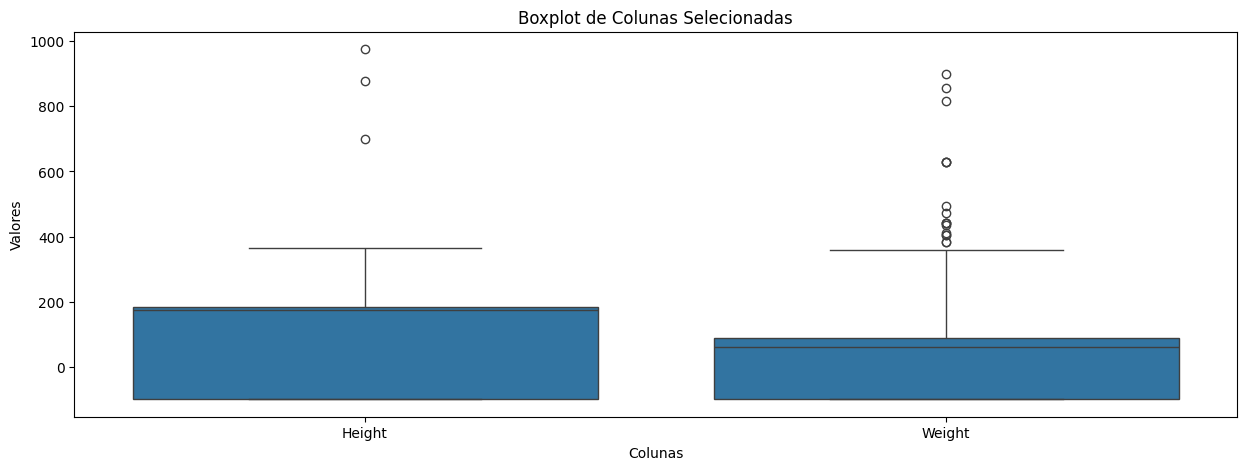

In [16]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=heroes_information[['Height', 'Weight']].melt(var_name='Colunas', value_name='Valores'), x='Colunas', y='Valores')
plt.title("Boxplot de Colunas Selecionadas")
plt.show()

In [17]:
len(heroes_information[(heroes_information.Height == -99) & (heroes_information.Weight == -99)])

211

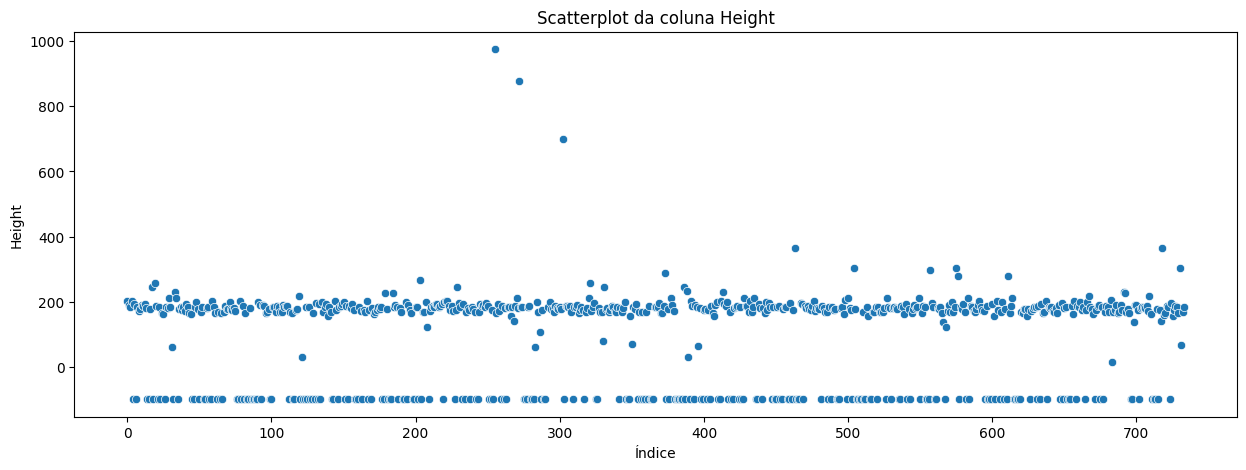

In [18]:
plt.figure(figsize=(15, 5))
sns.scatterplot(x=heroes_information.index, y=heroes_information['Height'])
plt.xlabel("Índice")
plt.ylabel('Height')
plt.title("Scatterplot da coluna Height")
plt.show()

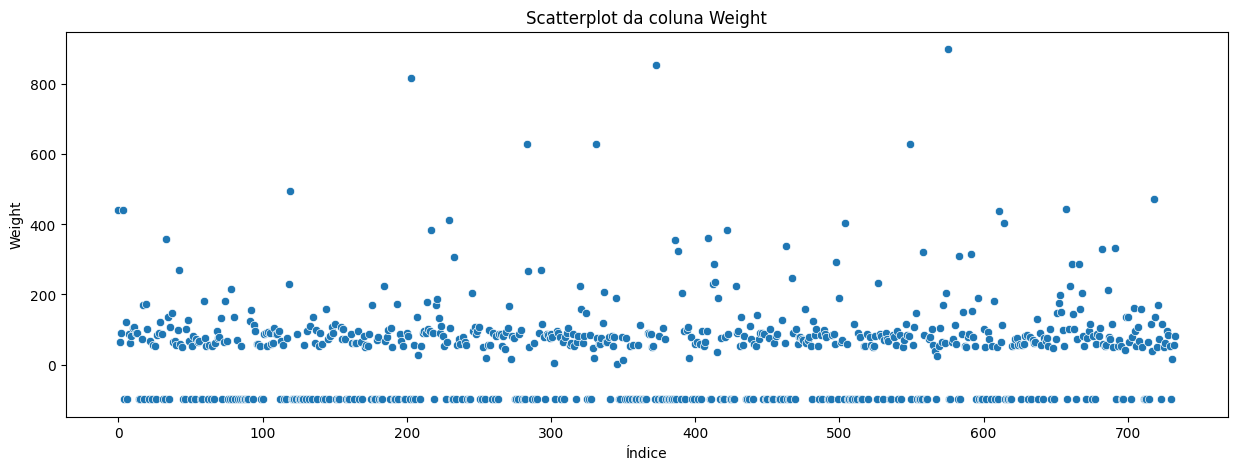

In [19]:
plt.figure(figsize=(15, 5))
sns.scatterplot(x=heroes_information.index, y=heroes_information['Weight'])
plt.xlabel("Índice")
plt.ylabel('Weight')
plt.title("Scatterplot da coluna Weight")
plt.show()

In [20]:
len99Height = len(heroes_information[heroes_information.Height == -99.0])
print(f"The column Height has {np.round((len99Height/len(heroes_information))*100)}% of NAN")

The column Height has 29.0% of NAN


In [21]:
len99Weight = len(heroes_information[heroes_information.Weight == -99.0])
print(f"The column Weight has {np.round((len99Weight/len(heroes_information))*100)}% of NAN")

The column Weight has 32.0% of NAN


In [ ]:
# retirei do dataset os casos onde Height e o Weight são -99
heroes_information = heroes_information[(heroes_information.Height != -99) & (heroes_information.Weight != -99)]

In [ ]:
# trasformei os -99 em NaN
heroes_information.replace(-99.0, np.nan, inplace=True)
# transformei os '-' em 'Unknown'
heroes_information.replace('-', 'Unknown' , inplace=True)

In [24]:
# os nulos que permaneceram nas colunas Height e Weight foram substituídos pela média.
heroes_information['Height'] = heroes_information['Height'].fillna(heroes_information['Height'].mean())
heroes_information['Weight'] = heroes_information['Weight'].fillna(heroes_information['Weight'].mean())

In [25]:
# Os nulos da coluna Publisher foram transformados em "Unknown"
heroes_information['Publisher'] = heroes_information['Publisher'].fillna("Unknown")

In [26]:
nulos_por_coluna = heroes_information.isnull().sum()
print(nulos_por_coluna)

name          0
Gender        0
Eye color     0
Race          0
Hair color    0
Height        0
Publisher     0
Skin color    0
Alignment     0
Weight        0
dtype: int64


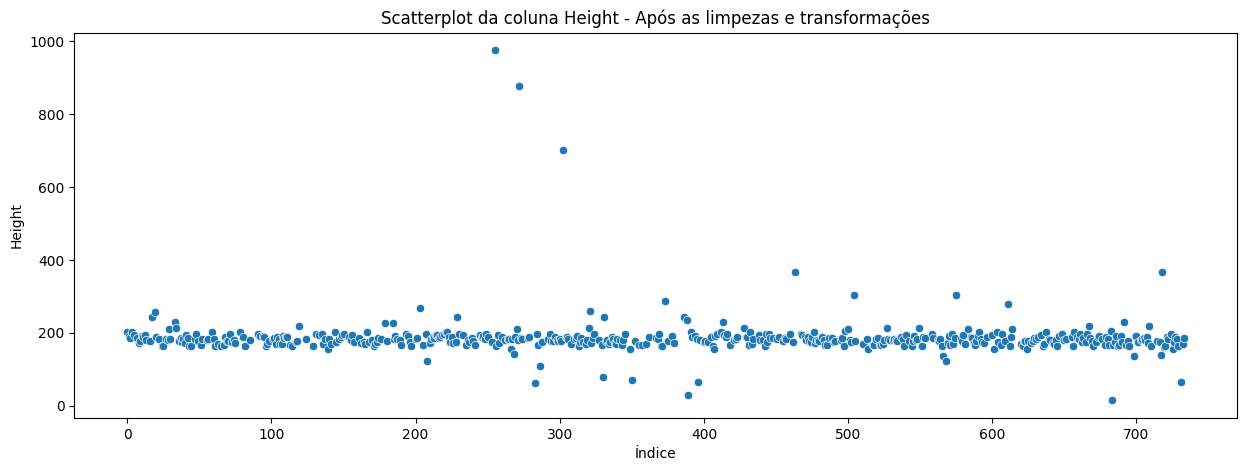

In [30]:
plt.figure(figsize=(15, 5))
sns.scatterplot(x=heroes_information.index, y=heroes_information['Height'])
plt.xlabel("Índice")
plt.ylabel('Height')
plt.title("Scatterplot da coluna Height - Após as limpezas e transformações")
plt.show()

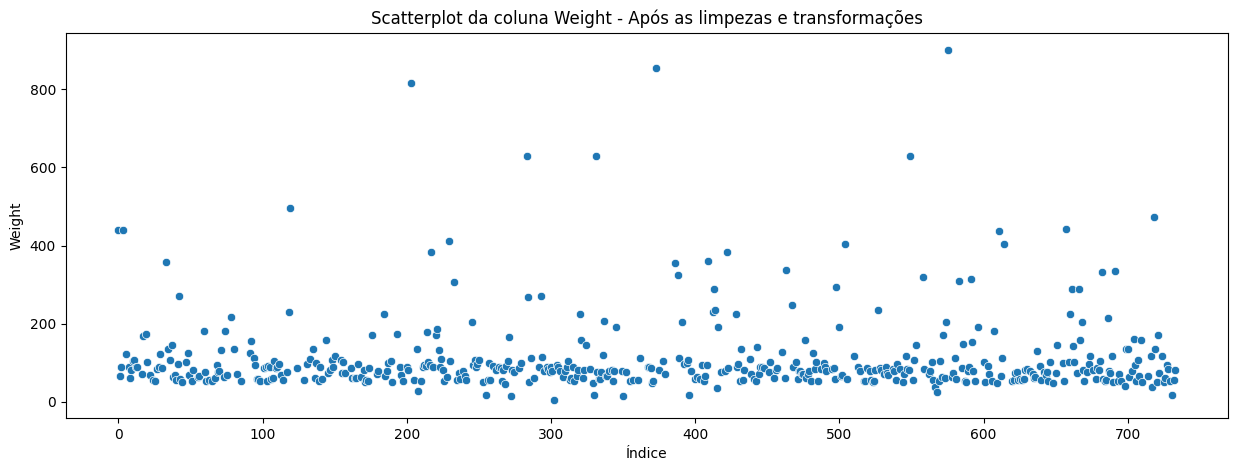

In [29]:
plt.figure(figsize=(15, 5))
sns.scatterplot(x=heroes_information.index, y=heroes_information['Weight'])
plt.xlabel("Índice")
plt.ylabel('Weight')
plt.title("Scatterplot da coluna Weight - Após as limpezas e transformações")
plt.show()

In [31]:
def remove_outliers_iqr(df, column):
    """
    Remove outliers de uma coluna em um DataFrame usando o método IQR.
    
    Parâmetros:
    - df: pandas.DataFrame - O DataFrame contendo os dados.
    - column: str - O nome da coluna na qual os outliers serão removidos.
    
    Retorna:
    - pandas.DataFrame - Um novo DataFrame sem os outliers na coluna especificada.
    """
    # Calcula o primeiro e o terceiro quartil (Q1 e Q3)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define os limites inferior e superior
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filtra os dados para remover os outliers
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return df_filtered


In [32]:
# Os outliers foram removidos usando o método IQR
heroes_information = remove_outliers_iqr(heroes_information, "Height")
heroes_information = remove_outliers_iqr(heroes_information, "Weight")

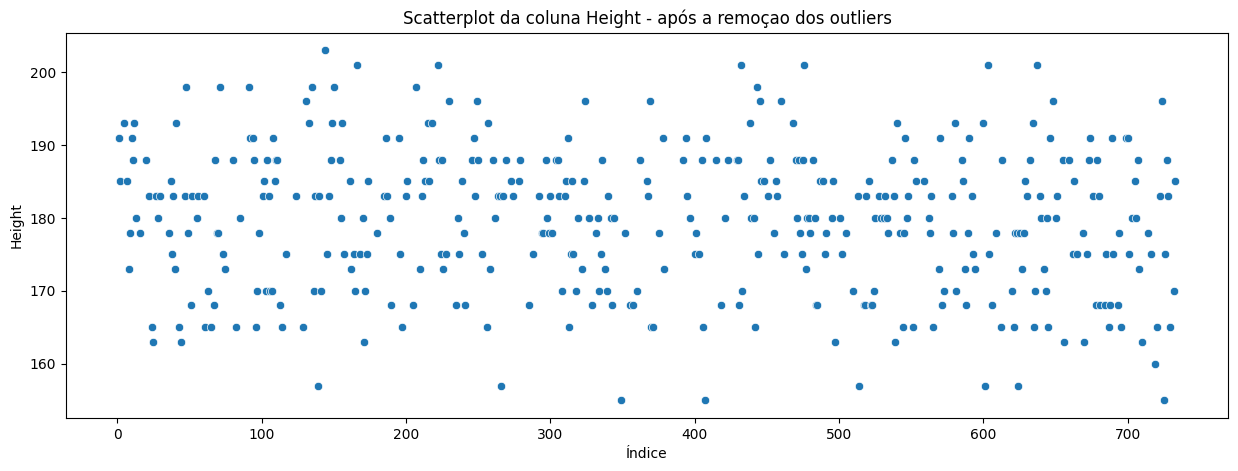

In [33]:
plt.figure(figsize=(15, 5))
sns.scatterplot(x=heroes_information.index, y=heroes_information['Height'])
plt.xlabel("Índice")
plt.ylabel('Height')
plt.title("Scatterplot da coluna Height - após a remoçao dos outliers")
plt.show()

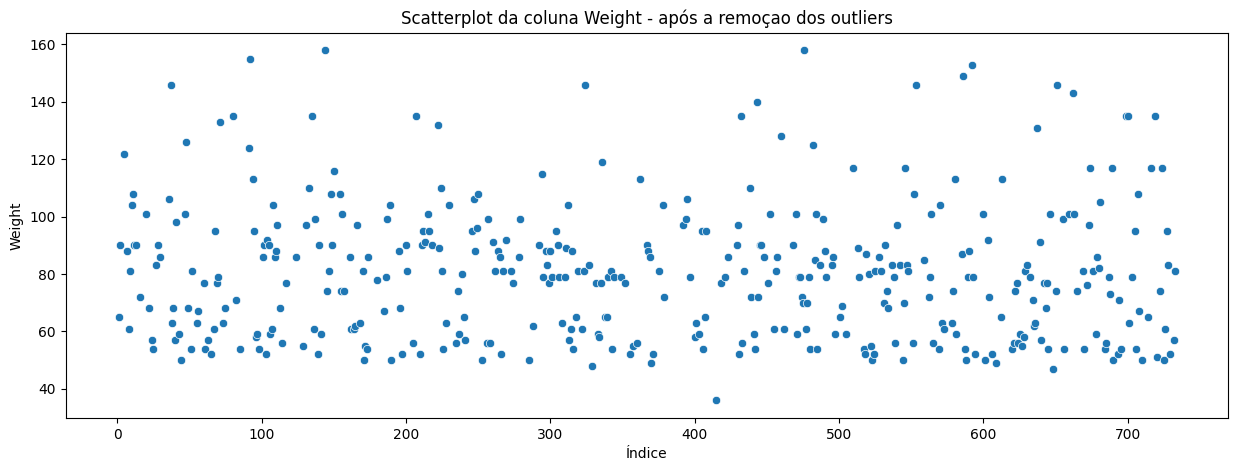

In [34]:
plt.figure(figsize=(15, 5))
sns.scatterplot(x=heroes_information.index, y=heroes_information['Weight'])
plt.xlabel("Índice")
plt.ylabel('Weight')
plt.title("Scatterplot da coluna Weight - após a remoçao dos outliers")
plt.show()

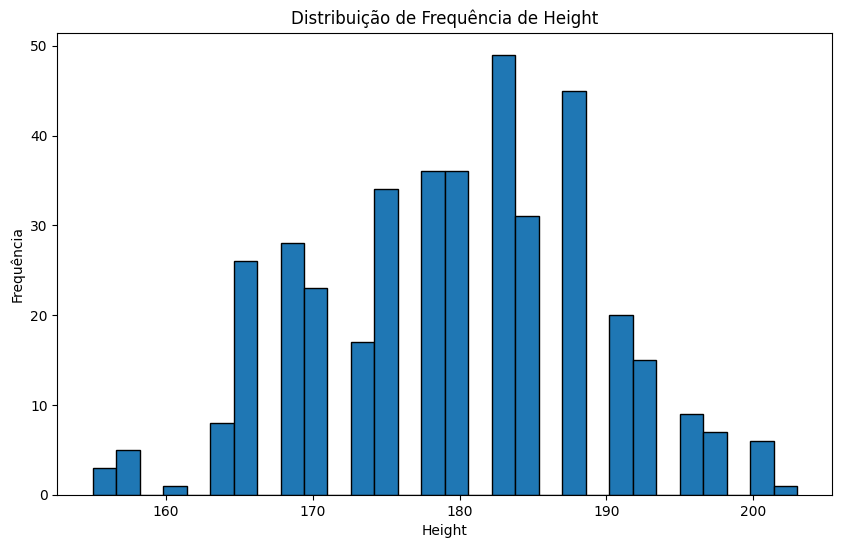

In [35]:
plt.figure(figsize=(10, 6))
plt.hist(heroes_information["Height"].dropna(), bins=30, edgecolor='black')
plt.xlabel("Height")
plt.ylabel('Frequência')
plt.title('Distribuição de Frequência de Height')
plt.show()

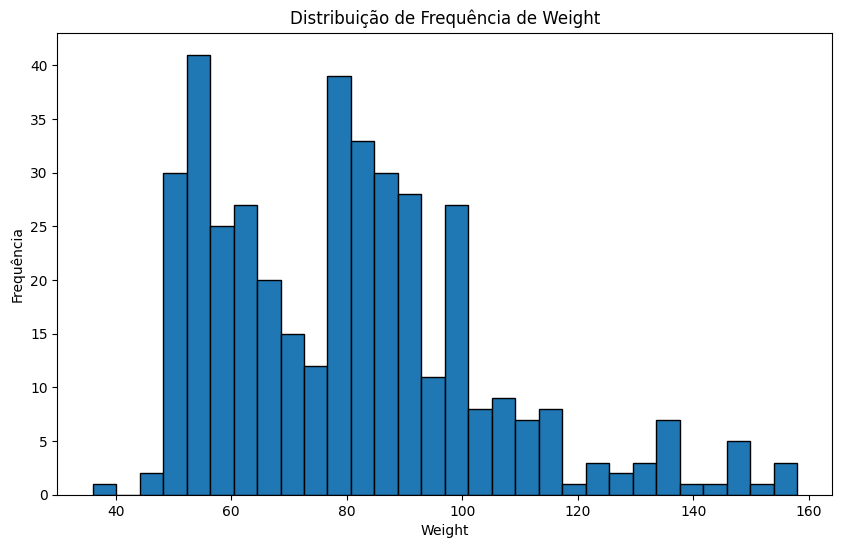

In [36]:
plt.figure(figsize=(10, 6))
plt.hist(heroes_information["Weight"].dropna(), bins=30, edgecolor='black')
plt.xlabel("Weight")
plt.ylabel('Frequência')
plt.title('Distribuição de Frequência de Weight')
plt.show()

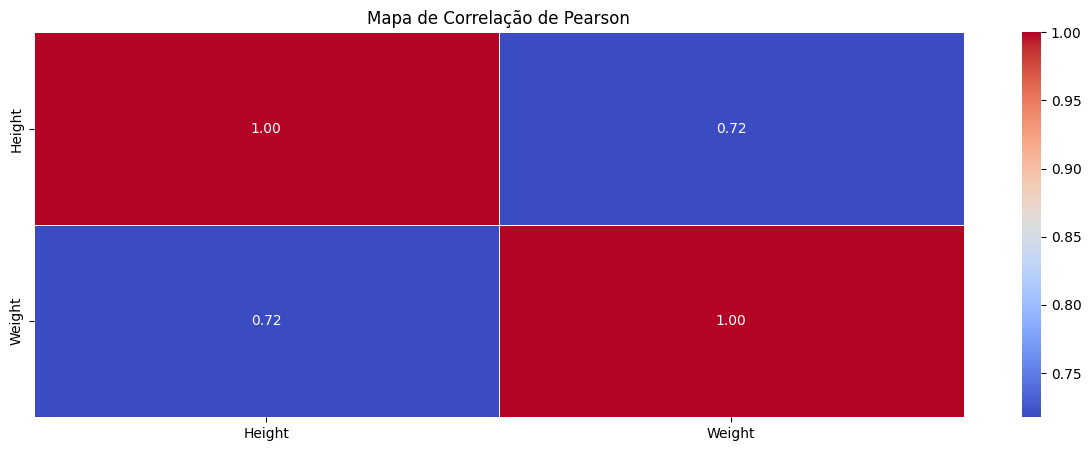

In [37]:
plt.figure(figsize=(15, 5))
sns.heatmap(heroes_information[['Height', 'Weight']].corr(method='pearson'), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Mapa de Correlação de Pearson")
plt.show()

In [38]:
filtro_unknown = heroes_information[(heroes_information['Eye color'] == "Unknown") & (heroes_information['Race'] == "Unknown") & (heroes_information['Hair color'] == "Unknown")]
print(len(filtro_unknown))
filtro_unknown.head(5)

4


,name,Gender,Eye color,Race,Hair color,Height,Publisher,Skin color,Alignment,Weight
10,Agent Zero,Male,Unknown,Unknown,Unknown,191.0,Marvel Comics,Unknown,good,104.0
113,Bling!,Female,Unknown,Unknown,Unknown,168.0,Marvel Comics,Unknown,good,68.0
300,Green Goblin III,Male,Unknown,Unknown,Unknown,183.0,Marvel Comics,Unknown,good,88.0
680,Two-Face,Male,Unknown,Unknown,Unknown,183.0,DC Comics,Unknown,bad,82.0


In [39]:
len(heroes_information)

400

In [40]:
heroes_information = heroes_information[~((heroes_information['Eye color'] == "Unknown") & 
                                                   (heroes_information['Race'] == "Unknown") & 
                                                   (heroes_information['Hair color'] == "Unknown"))]

In [41]:
len(heroes_information)

396

In [42]:
def cramers_v(x, y):
    """Calcula o valor de Cramér's V entre duas variáveis categóricas."""
    contingency_table = pd.crosstab(x, y)
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    r, k = contingency_table.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

def mapa_correlacao_categorica(df: pd.DataFrame, cols: List[str]) -> None:
    """Cria um mapa de correlação para variáveis categóricas usando Cramér's V."""
    # Inicializar uma matriz para armazenar os valores de Cramér's V
    matriz = pd.DataFrame(np.zeros((len(cols), len(cols))), index=cols, columns=cols)
    
    # Calcular Cramér's V para cada par de colunas
    for i in range(len(cols)):
        for j in range(i, len(cols)):
            if i == j:
                matriz.iloc[i, j] = 1.0
            else:
                matriz.iloc[i, j] = cramers_v(df[cols[i]], df[cols[j]])
                matriz.iloc[j, i] = matriz.iloc[i, j]
    
    # Plotar o mapa de calor
    plt.figure(figsize=(15, 5))
    sns.heatmap(matriz, annot=True, cmap="coolwarm", vmin=0, vmax=1, fmt=".2f", linewidths=0.5)
    plt.title("Mapa de Correlação para Variáveis Categóricas (Cramér's V)")
    plt.show()


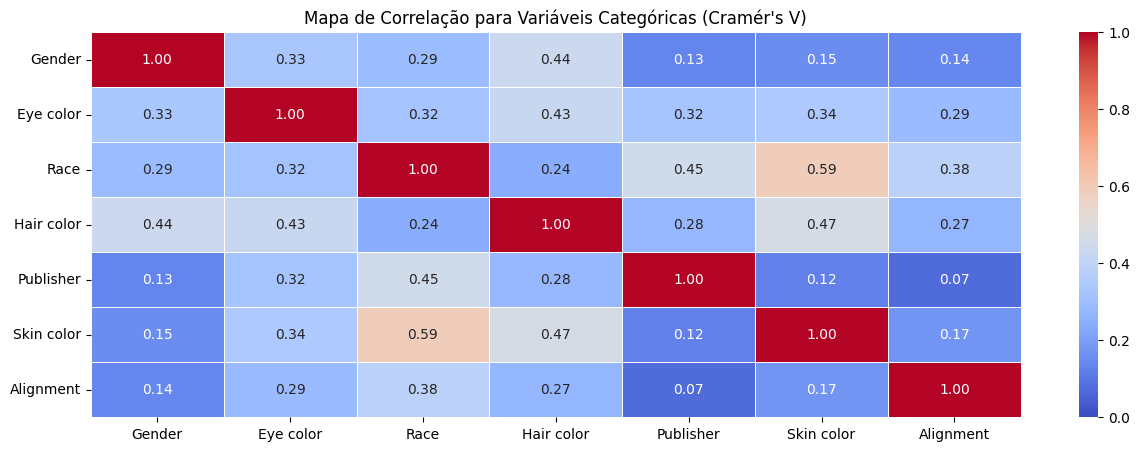

In [43]:
cat_cols = ['Gender', 'Eye color', 'Race', 'Hair color', 'Publisher', 'Skin color', 'Alignment']
mapa_correlacao_categorica(heroes_information, cat_cols)

In [44]:
len(heroes_information)

396

In [45]:
heroes_information.head(30)

,name,Gender,Eye color,Race,Hair color,Height,Publisher,Skin color,Alignment,Weight
1,Abe Sapien,Male,blue,Icthyo Sapien,No Hair,191.0,Dark Horse Comics,blue,good,65.0
2,Abin Sur,Male,blue,Ungaran,No Hair,185.0,DC Comics,red,good,90.0
5,Absorbing Man,Male,blue,Human,No Hair,193.0,Marvel Comics,Unknown,bad,122.0
7,Adam Strange,Male,blue,Human,Blond,185.0,DC Comics,Unknown,good,88.0
8,Agent 13,Female,blue,Unknown,Blond,173.0,Marvel Comics,Unknown,good,61.0
9,Agent Bob,Male,brown,Human,Brown,178.0,Marvel Comics,Unknown,good,81.0
11,Air-Walker,Male,blue,Unknown,White,188.0,Marvel Comics,Unknown,bad,108.0
12,Ajax,Male,brown,Cyborg,Black,193.0,Marvel Comics,Unknown,bad,90.0
13,Alan Scott,Male,blue,Unknown,Blond,180.0,DC Comics,Unknown,good,90.0
16,Alfred Pennyworth,Male,blue,Human,Black,178.0,DC Comics,Unknown,good,72.0


In [46]:
heroes_information['Skin color'].value_counts(normalize=True)

Skin color
Unknown    0.909091
green      0.022727
red        0.015152
blue       0.015152
white      0.012626
silver     0.007576
gold       0.005051
pink       0.002525
grey       0.002525
purple     0.002525
orange     0.002525
yellow     0.002525
Name: proportion, dtype: float64

In [47]:
len(heroes_information['Race'].unique())

38

In [48]:
heroes_information['Race'].value_counts(normalize=True)

Race
Unknown              0.356061
Human                0.356061
Mutant               0.111111
Android              0.012626
Alien                0.012626
Atlantean            0.012626
Symbiote             0.012626
Human / Radiation    0.012626
Kryptonian           0.010101
Inhuman              0.010101
Cyborg               0.007576
Demon                0.007576
Amazon               0.005051
Human-Kree           0.005051
Demi-God             0.005051
New God              0.005051
Saiyan               0.005051
Ungaran              0.002525
Icthyo Sapien        0.002525
Metahuman            0.002525
God / Eternal        0.002525
Neyaphem             0.002525
Zen-Whoberian        0.002525
Vampire              0.002525
Bizarro              0.002525
Human-Vuldarian      0.002525
Martian              0.002525
Human / Altered      0.002525
Luphomoid            0.002525
Human / Cosmic       0.002525
Clone                0.002525
Talokite             0.002525
Korugaran            0.002525
Human

In [49]:
heroes_information = heroes_information.drop('Skin color', axis=1)

In [50]:
len(heroes_information)

396

In [51]:
heroes_information.name.value_counts()

name
Spider-Man        3
Toxin             2
Nova              2
Captain Marvel    2
Black Canary      2
                 ..
Annihilus         1
Ant-Man II        1
Aqualad           1
Aquaman           1
Adam Strange      1
Name: count, Length: 388, dtype: int64

In [52]:
heroes_information[heroes_information.name == "Spider-Man"].head()

,name,Gender,Eye color,Race,Hair color,Height,Publisher,Alignment,Weight
622,Spider-Man,Male,hazel,Human,Brown,178.0,Marvel Comics,good,74.0
623,Spider-Man,Unknown,red,Human,Brown,178.0,Marvel Comics,good,77.0
624,Spider-Man,Male,brown,Human,Black,157.0,Marvel Comics,good,56.0


In [53]:
heroes_information[heroes_information.name == "Nova"].head()

,name,Gender,Eye color,Race,Hair color,Height,Publisher,Alignment,Weight
496,Nova,Male,brown,Human,Brown,185.0,Marvel Comics,good,86.0
497,Nova,Female,white,Human / Cosmic,Red,163.0,Marvel Comics,good,59.0


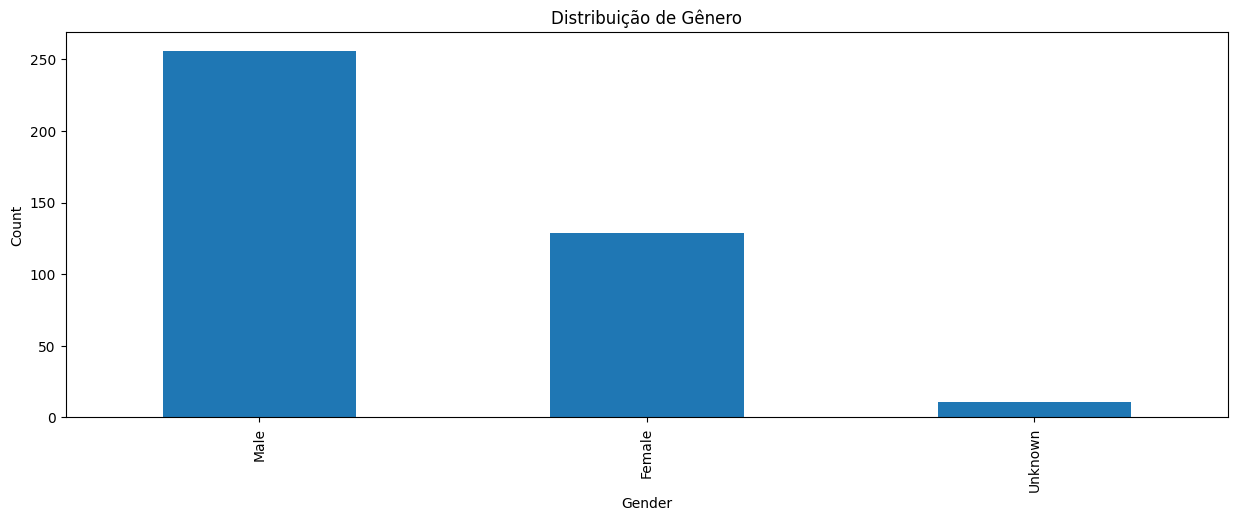

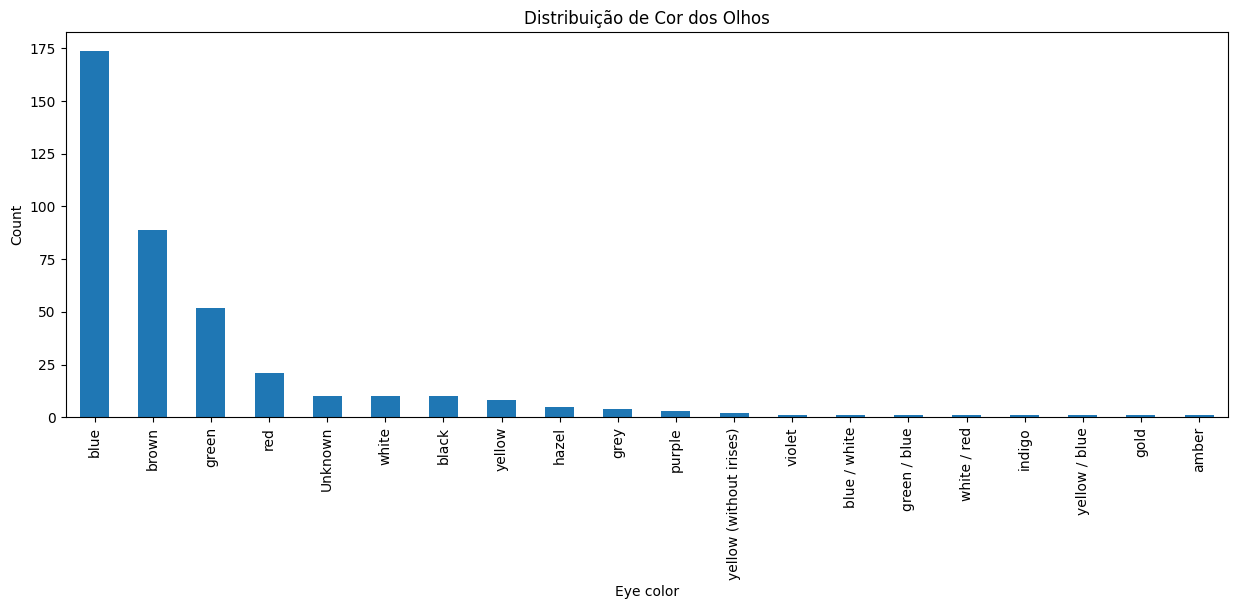

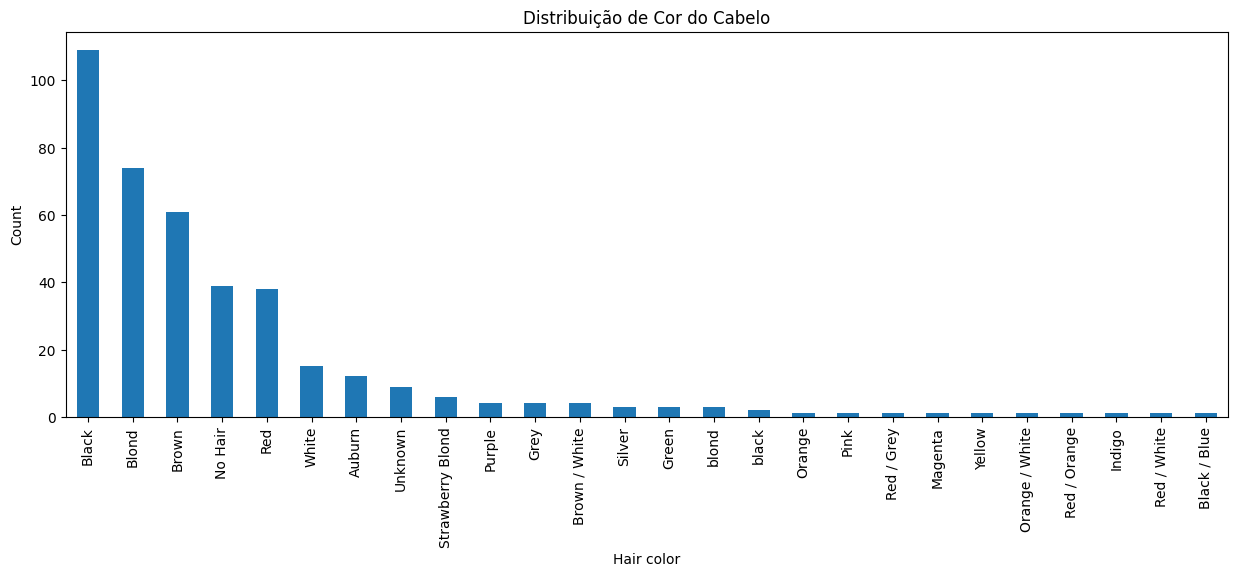

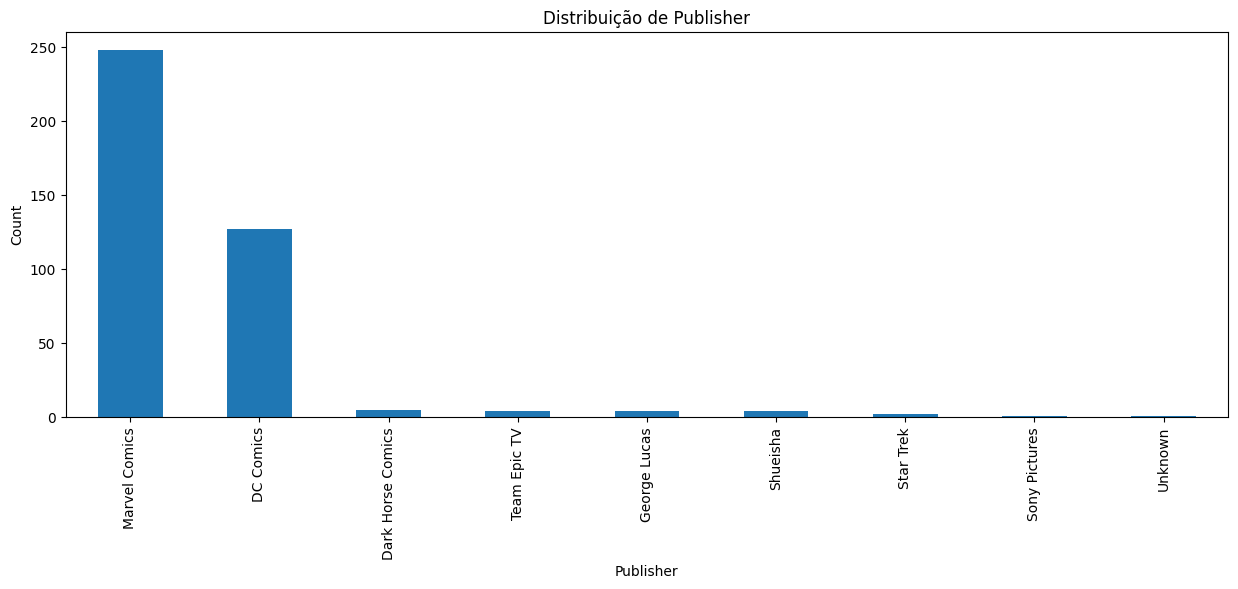

<Figure size 1500x500 with 0 Axes>

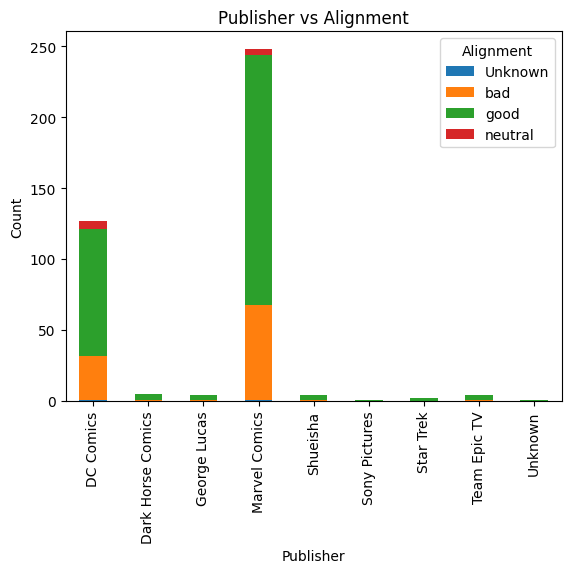

In [54]:
# Gráfico 1: Distribuição de Gênero
plt.figure(figsize=(15, 5))
heroes_information['Gender'].value_counts().plot(kind='bar', title='Distribuição de Gênero')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# Gráfico 4: Distribuição de Cor dos Olhos
plt.figure(figsize=(15, 5))
heroes_information['Eye color'].value_counts().plot(kind='bar', title='Distribuição de Cor dos Olhos')
plt.xlabel('Eye color')
plt.ylabel('Count')
plt.show()

# Gráfico 5: Distribuição de Cor do Cabelo
plt.figure(figsize=(15, 5))
heroes_information['Hair color'].value_counts().plot(kind='bar', title='Distribuição de Cor do Cabelo')
plt.xlabel('Hair color')
plt.ylabel('Count')
plt.show()

# Gráfico 6: Distribuição de Publisher
plt.figure(figsize=(15, 5))
heroes_information['Publisher'].value_counts().plot(kind='bar', title='Distribuição de Publisher')
plt.xlabel('Publisher')
plt.ylabel('Count')
plt.show()

# Gráfico 7: Relação entre Publisher e Alignment
plt.figure(figsize=(15, 5))
pd.crosstab(heroes_information['Publisher'], heroes_information['Alignment']).plot(kind='bar', stacked=True, title='Publisher vs Alignment')
plt.xlabel('Publisher')
plt.ylabel('Count')
plt.show()

## Super Hero Powers

In [55]:
super_hero_powers.head(3)

,Agility,Accelerated Healing,Lantern Power Ring,Dimensional Awareness,Cold Resistance,Durability,Stealth,Energy Absorption,Flight,Danger Sense,Underwater breathing,Marksmanship,Weapons Master,Power Augmentation,Animal Attributes,Longevity,Intelligence,Super Strength,Cryokinesis,Telepathy,Energy Armor,Energy Blasts,Duplication,Size Changing,Density Control,Stamina,Astral Travel,Audio Control,Dexterity,Omnitrix,Super Speed,Possession,Animal Oriented Powers,Weapon-based Powers,Electrokinesis,Darkforce Manipulation,Death Touch,Teleportation,Enhanced Senses,Telekinesis,Energy Beams,Magic,Hyperkinesis,Jump,Clairvoyance,Dimensional Travel,Power Sense,Shapeshifting,Peak Human Condition,Immortality,Camouflage,Element Control,Phasing,Astral Projection,Electrical Transport,Fire Control,Projection,Summoning,Enhanced Memory,Reflexes,Invulnerability,Energy Constructs,Force Fields,Self-Sustenance,Anti-Gravity,Empathy,Power Nullifier,Radiation Control,Psionic Powers,Elasticity,Substance Secretion,Elemental Transmogrification,Technopath/Cyberpath,Photographic Reflexes,Seismic Power,Animation,Precognition,Mind Control,Fire Resistance,Power Absorption,Enhanced Hearing,Nova Force,Insanity,Hypnokinesis,Animal Control,Natural Armor,Intangibility,Enhanced Sight,Molecular Manipulation,Heat Generation,Adaptation,Gliding,Power Suit,Mind Blast,Probability Manipulation,Gravity Control,Regeneration,Light Control,Echolocation,Levitation,Toxin and Disease Control,Banish,Energy Manipulation,Heat Resistance,Natural Weapons,Time Travel,Enhanced Smell,Illusions,Thirstokinesis,Hair Manipulation,Illumination,Omnipotent,Cloaking,Changing Armor,Power Cosmic,Biokinesis,Water Control,Radiation Immunity,Vision - Telescopic,Toxin and Disease Resistance,Spatial Awareness,Energy Resistance,Telepathy Resistance,Molecular Combustion,Omnilingualism,Portal Creation,Magnetism,Mind Control Resistance,Plant Control,Sonar,Sonic Scream,Time Manipulation,Enhanced Touch,Magic Resistance,Invisibility,Sub-Mariner,Radiation Absorption,Intuitive aptitude,Vision - Microscopic,Melting,Wind Control,Super Breath,Wallcrawling,Vision - Night,Vision - Infrared,Grim Reaping,Matter Absorption,The Force,Resurrection,Terrakinesis,Vision - Heat,Vitakinesis,Radar Sense,Qwardian Power Ring,Weather Control,Vision - X-Ray,Vision - Thermal,Web Creation,Reality Warping,Odin Force,Symbiote Costume,Speed Force,Phoenix Force,Molecular Dissipation,Vision - Cryo,Omnipresent,Omniscient
hero_names,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3-D Man,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
A-Bomb,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,Fa

In [56]:
super_hero_powers.reset_index(inplace=True)

In [57]:
super_hero_powers.head()

,hero_names,Agility,Accelerated Healing,Lantern Power Ring,Dimensional Awareness,Cold Resistance,Durability,Stealth,Energy Absorption,Flight,Danger Sense,Underwater breathing,Marksmanship,Weapons Master,Power Augmentation,Animal Attributes,Longevity,Intelligence,Super Strength,Cryokinesis,Telepathy,Energy Armor,Energy Blasts,Duplication,Size Changing,Density Control,Stamina,Astral Travel,Audio Control,Dexterity,Omnitrix,Super Speed,Possession,Animal Oriented Powers,Weapon-based Powers,Electrokinesis,Darkforce Manipulation,Death Touch,Teleportation,Enhanced Senses,Telekinesis,Energy Beams,Magic,Hyperkinesis,Jump,Clairvoyance,Dimensional Travel,Power Sense,Shapeshifting,Peak Human Condition,Immortality,Camouflage,Element Control,Phasing,Astral Projection,Electrical Transport,Fire Control,Projection,Summoning,Enhanced Memory,Reflexes,Invulnerability,Energy Constructs,Force Fields,Self-Sustenance,Anti-Gravity,Empathy,Power Nullifier,Radiation Control,Psionic Powers,Elasticity,Substance Secretion,Elemental Transmogrification,Technopath/Cyberpath,Photographic Reflexes,Seismic Power,Animation,Precognition,Mind Control,Fire Resistance,Power Absorption,Enhanced Hearing,Nova Force,Insanity,Hypnokinesis,Animal Control,Natural Armor,Intangibility,Enhanced Sight,Molecular Manipulation,Heat Generation,Adaptation,Gliding,Power Suit,Mind Blast,Probability Manipulation,Gravity Control,Regeneration,Light Control,Echolocation,Levitation,Toxin and Disease Control,Banish,Energy Manipulation,Heat Resistance,Natural Weapons,Time Travel,Enhanced Smell,Illusions,Thirstokinesis,Hair Manipulation,Illumination,Omnipotent,Cloaking,Changing Armor,Power Cosmic,Biokinesis,Water Control,Radiation Immunity,Vision - Telescopic,Toxin and Disease Resistance,Spatial Awareness,Energy Resistance,Telepathy Resistance,Molecular Combustion,Omnilingualism,Portal Creation,Magnetism,Mind Control Resistance,Plant Control,Sonar,Sonic Scream,Time Manipulation,Enhanced Touch,Magic Resistance,Invisibility,Sub-Mariner,Radiation Absorption,Intuitive aptitude,Vision - Microscopic,Melting,Wind Control,Super Breath,Wallcrawling,Vision - Night,Vision - Infrared,Grim Reaping,Matter Absorption,The Force,Resurrection,Terrakinesis,Vision - Heat,Vitakinesis,Radar Sense,Qwardian Power Ring,Weather Control,Vision - X-Ray,Vision - Thermal,Web Creation,Reality Warping,Odin Force,Symbiote Costume,Speed Force,Phoenix Force,Molecular Dissipation,Vision - Cryo,Omnipresent,Omniscient
0,3-D Man,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,A-Bomb,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fals

In [58]:
super_hero_powers.hero_names.value_counts()

hero_names
Zoom            1
3-D Man         1
A-Bomb          1
Abe Sapien      1
Abin Sur        1
               ..
Alex Woolsly    1
Alex Mercer     1
Alan Scott      1
Ajax            1
Air-Walker      1
Name: count, Length: 667, dtype: int64

In [59]:
for coluna in super_hero_powers.columns:
    qtd_nulos = super_hero_powers[coluna].isnull().sum()
    if qtd_nulos > 0:
        print(f"Coluna '{coluna}' possui {qtd_nulos} valores nulos.")

In [60]:
for coluna in super_hero_powers.columns:
    qtd_hifens = (super_hero_powers[coluna] == "-").sum()
    if qtd_hifens > 0:
        print(f"Coluna '{coluna}' possui {qtd_hifens} valores com '-'.")

In [61]:
super_hero_powers.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667 entries, 0 to 666
Data columns (total 168 columns):
 #    Column                        Non-Null Count  Dtype 
---   ------                        --------------  ----- 
 0    hero_names                    667 non-null    object
 1    Agility                       667 non-null    bool  
 2    Accelerated Healing           667 non-null    bool  
 3    Lantern Power Ring            667 non-null    bool  
 4    Dimensional Awareness         667 non-null    bool  
 5    Cold Resistance               667 non-null    bool  
 6    Durability                    667 non-null    bool  
 7    Stealth                       667 non-null    bool  
 8    Energy Absorption             667 non-null    bool  
 9    Flight                        667 non-null    bool  
 10   Danger Sense                  667 non-null    bool  
 11   Underwater breathing          667 non-null    bool  
 12   Marksmanship                  667 non-null    bool  
 13   Wea

In [62]:
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

cramers_v_matrix = pd.DataFrame(np.zeros((super_hero_powers.shape[1], super_hero_powers.shape[1])), columns=super_hero_powers.columns, index=super_hero_powers.columns)

for col1 in super_hero_powers.columns:
    for col2 in super_hero_powers.columns:
        if col1 != col2:
            cramers_v_matrix.loc[col1, col2] = cramers_v(super_hero_powers[col1], super_hero_powers[col2])

In [63]:
cramers_v_matrix.head(10)

,hero_names,Agility,Accelerated Healing,Lantern Power Ring,Dimensional Awareness,Cold Resistance,Durability,Stealth,Energy Absorption,Flight,Danger Sense,Underwater breathing,Marksmanship,Weapons Master,Power Augmentation,Animal Attributes,Longevity,Intelligence,Super Strength,Cryokinesis,Telepathy,Energy Armor,Energy Blasts,Duplication,Size Changing,Density Control,Stamina,Astral Travel,Audio Control,Dexterity,Omnitrix,Super Speed,Possession,Animal Oriented Powers,Weapon-based Powers,Electrokinesis,Darkforce Manipulation,Death Touch,Teleportation,Enhanced Senses,Telekinesis,Energy Beams,Magic,Hyperkinesis,Jump,Clairvoyance,Dimensional Travel,Power Sense,Shapeshifting,Peak Human Condition,Immortality,Camouflage,Element Control,Phasing,Astral Projection,Electrical Transport,Fire Control,Projection,Summoning,Enhanced Memory,Reflexes,Invulnerability,Energy Constructs,Force Fields,Self-Sustenance,Anti-Gravity,Empathy,Power Nullifier,Radiation Control,Psionic Powers,Elasticity,Substance Secretion,Elemental Transmogrification,Technopath/Cyberpath,Photographic Reflexes,Seismic Power,Animation,Precognition,Mind Control,Fire Resistance,Power Absorption,Enhanced Hearing,Nova Force,Insanity,Hypnokinesis,Animal Control,Natural Armor,Intangibility,Enhanced Sight,Molecular Manipulation,Heat Generation,Adaptation,Gliding,Power Suit,Mind Blast,Probability Manipulation,Gravity Control,Regeneration,Light Control,Echolocation,Levitation,Toxin and Disease Control,Banish,Energy Manipulation,Heat Resistance,Natural Weapons,Time Travel,Enhanced Smell,Illusions,Thirstokinesis,Hair Manipulation,Illumination,Omnipotent,Cloaking,Changing Armor,Power Cosmic,Biokinesis,Water Control,Radiation Immunity,Vision - Telescopic,Toxin and Disease Resistance,Spatial Awareness,Energy Resistance,Telepathy Resistance,Molecular Combustion,Omnilingualism,Portal Creation,Magnetism,Mind Control Resistance,Plant Control,Sonar,Sonic Scream,Time Manipulation,Enhanced Touch,Magic Resistance,Invisibility,Sub-Mariner,Radiation Absorption,Intuitive aptitude,Vision - Microscopic,Melting,Wind Control,Super Breath,Wallcrawling,Vision - Night,Vision - Infrared,Grim Reaping,Matter Absorption,The Force,Resurrection,Terrakinesis,Vision - Heat,Vitakinesis,Radar Sense,Qwardian Power Ring,Weather Control,Vision - X-Ray,Vision - Thermal,Web Creation,Reality Warping,Odin Force,Symbiote Costume,Speed Force,Phoenix Force,Molecular Dissipation,Vision - Cryo,Omnipresent,Omniscient
hero_names,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Agility,1.0,0.000000,0.253207,0.012462,0.023468,0

In [64]:
len(cramers_v_matrix)

168

In [65]:
for i in cramers_v_matrix.columns:
    le = len(cramers_v_matrix[cramers_v_matrix[i] > 0.8])
    if le > 0:
        print(f"{i}, qtd of rows {le}")

hero_names, qtd of rows 167
Agility, qtd of rows 1
Accelerated Healing, qtd of rows 1
Lantern Power Ring, qtd of rows 1
Dimensional Awareness, qtd of rows 1
Cold Resistance, qtd of rows 1
Durability, qtd of rows 1
Stealth, qtd of rows 1
Energy Absorption, qtd of rows 1
Flight, qtd of rows 1
Danger Sense, qtd of rows 1
Underwater breathing, qtd of rows 1
Marksmanship, qtd of rows 1
Weapons Master, qtd of rows 1
Power Augmentation, qtd of rows 1
Animal Attributes, qtd of rows 1
Longevity, qtd of rows 1
Intelligence, qtd of rows 1
Super Strength, qtd of rows 1
Cryokinesis, qtd of rows 1
Telepathy, qtd of rows 1
Energy Armor, qtd of rows 1
Energy Blasts, qtd of rows 1
Duplication, qtd of rows 1
Size Changing, qtd of rows 1
Density Control, qtd of rows 1
Stamina, qtd of rows 1
Astral Travel, qtd of rows 1
Audio Control, qtd of rows 1
Dexterity, qtd of rows 1
Omnitrix, qtd of rows 1
Super Speed, qtd of rows 1
Possession, qtd of rows 1
Animal Oriented Powers, qtd of rows 1
Weapon-based Powers

# FIM